## Digit Classification ##

While studying computer vision and deep learning, I figured I should do something in my own time to use some of my skills. The purpose of this is to explore ground-up image recognition, in the extremely simple example of recognizing handwritten digits on a piece of paper. I was inspired by the incredible real-time processing developed by Google Translate for their image translation technology. Right now, I'm working through this problem in this notebook alone, but as I progress, I'll be scripting it into a bare-bones application. 

Let's start with some libraries and a basic preprocessing function to make input compatible with numpy.

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from scipy import stats
from PIL import Image

In [5]:
def readGray(filename):
    img = color.rgb2gray(io.imread(filename))
    return np.around(255 * img).astype(np.uint8)

In [6]:
im = readGray("handwritten.png")

I'm using a simple testing image, with 16 instances of MNIST digits arranged in a 4x4 grid on a white background.

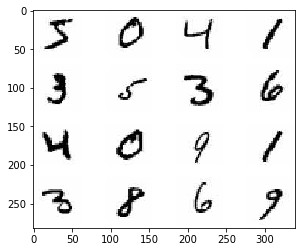

In [19]:
plt.imshow(im, cmap = 'gray')

### Gradient ###
Gradients are useful throughout vision problems; here I want to use a gradient function to find the edges of objects. As a part of preprocessing, these edges will help me identify square areas of an image that correspond to individual digits. 

In [8]:
def grad_mag(image):
    # Return array with flat (x and y) gradient magnitudes for each pixel; same aspect ratio
    m,n = np.shape(image)
    image = np.ndarray.astype(image, dtype = 'float')
    std = np.std(image)
    
    #initialize arrays for magnitude calculation
    res_x = np.zeros([m,n])
    res_y = np.zeros([m,n])
    res = np.zeros([m,n])
    
    for i in range(1,m-1):
        for j in range(1,n-1):
            
            #simple before-after gradient masks applied for x, y 
            res_x[i,j] = (image[i,j-1] - image[i,j+1])
            res_y[i,j] = (image[i-1,j] - image[i+1,j])
            res[i,j] = np.sqrt(res_x[i,j]**2 + res_y[i,j]**2)
            
            #filter for minimum brightness change
            if (res[i,j] < 100): res[i,j] = 0
    
    return res

This next function will be used later to resize the selected areas of our input image into the same dimensions as the input data that our digit recognizer will be trained on.

In [171]:
def resize_square(image, size = [28,28]):
    
    #cheating a bit here, using external library to 
    #resize found digits to match CNN input dimension
    image = Image.fromarray(image)
    image = np.invert(np.array(image.resize(size)))
    return image

### More preprocessing; digit boundaries ###

With the gradient function, we made an array of the same size as our input image with non-zero values at the edges of image features. By using that as a reference, these next two (very bulky and highly improvable) functions find squares that contain unique image features (with a big assumption of no occlusion) and output selections from the input image that correspond to image feature boundaries.

In [10]:
def scan_y(image, y, n):
    for i in range(n):
        if (image[y,i] > 0):
            return True
        else: return False
        
def scan_x(image, x, m):
    for i in range(0,m):
        if(image[i,x] > 0):
            return True
        else: return False

        
def find_squares_grid(image):
    gradient = grad_mag(image)
    m,n = np.shape(gradient)
    lines = []
    bounds_y = []
    squares = []
    res = []
    value_1 = False
    value_2 = False
    mode = (stats.mode(np.ravel(im))[0])
    
    for i in range(m):
        if (bool(scan_y(gradient, i, n)) ^ bool(value_1)):
            bounds_y.append(i)
        value_1 = scan_y(gradient,i,n)
    
    for i in range(0,len(bounds_y)-1,2):
            lines.append(image[bounds_y[i]:bounds_y[i+1],:])
            
    for line in lines:
        
        y,x = np.shape(line)
        line_grad = grad_mag(line)
        bounds_x = []
        
        for i in range(x):
            if (bool(scan_x(line_grad, i, y)) ^ bool(value_2)):
                bounds_x.append(i)
            value_2 = scan_x(line_grad, i, y)
        
        for i in range(0,len(bounds_x)-1,2):
            square = line[:,bounds_x[i]:bounds_x[i+1]]
            y, x = np.shape(square)
            pad = np.int(abs(np.round((y-x)/2)))
            if (y>x):
                bezel = np.full((y,pad),mode)
                square = np.concatenate([square, bezel], axis=1)
                square = np.concatenate([bezel, square], axis=1)
            if (x>y):
                bezel = np.full((pad,x),mode)
                square = np.concatenate([square, bezel], axis=0)
                square = np.concatenate([bezel, square], axis=0)
        
            squares.append(resize_square(square))
            
    return squares
        
    
    

### An attempt at generalization ###

The function above is pretty fast, and works by splitting an image into a grid; selecting slices where there is no gradient (no edges), and then splitting those slices into squares that will surround features (digits) in the original input array. The next function is a bit more generalizable, by scaling up a square, and searching for the correct size and location such that the square boundaries surround a digit. By keeping a copy of the input image and deleting areas where it's already found a fit, it finds and outputs each digit only once. 

In [172]:
def find_squares_anywhere(image, smallest, largest, stride):
    
    gradient = grad_mag(image)
    m,n = np.shape(gradient)
    squares = []
    locs = []
    res = []
    max_count = 0
    stop = 0
    tests = []
    index = 0
    
    for k in range(smallest, largest, 2):
        
        gradient_copy = gradient
        count = 0
        
        for i in range(0,n-k,stride):
            for j in range(0,m-k,stride):
                
                window = gradient_copy[j:j+k,i:i+k]
                
                if(np.sum(window) >= (np.std(gradient)*((k**2)/8))):
                    a = np.sum(window[0,:])
                    b = np.sum(window[k-1,:])
                    c = np.sum(window[:,0])
                    d = np.sum(window[:,k-1])
                    if (a + b + c + d < np.std(gradient)*4):
                        selection = image[j:j+k,i:i+k]
                        squares.append(resize_square(selection))
                        gradient_copy[j:j+k,i:i+k] = 0
                        count += 1
                        locs.append([index,j,i])
                        index += 1
        if (count >= max_count):
            max_count = count
        else: 
            stop += 1
            if (stop > 1): break
            continue
    locs = pd.DataFrame(np.array(locs))
    locs = locs.sort_values(by=[locs.columns[1], locs.columns[2]])
    for item in np.array(locs):
        index = item[0]
        res.append(squares[index])
    
    
    return res        

### Testing the preprocessor ###

Let's take a look at how it works. I'm running a test on the general function, and displaying the output array with pyplot.

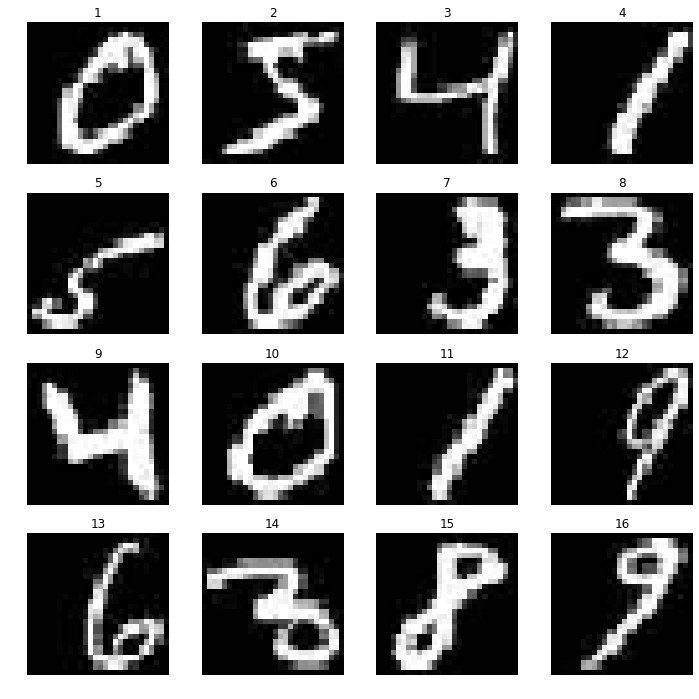

In [178]:
test = find_squares_anywhere(im, 10, 50, 2)
fig2 = plt.figure(figsize = (12,12))
cols = 4
rows = 4
for i in range(1,17):
    fig2.add_subplot(rows,cols,i)
    plt.imshow(res[i-1],cmap = 'gray')
    plt.title(i)
    plt.axis('off')
plt.show(fig2)

### Success! ###

That looks pretty good to start, we got 16 numbers and no duplicates. 

Now, I'm going to fire up Keras with Tensorflow backend, and use MNIST Digits to train a simple CNN I wrote. The people love convolutional networks, so I'm doing a bit more work with my comments here. If you've looked through the rest of my github, this network is suspciously similar to something I wrote for a kaggle competition. If it's powerful enough for Fashion-MNIST, it's more than enough for some digit classification.

In [76]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
import torchvision
import tensorflow
from sklearn.model_selection import train_test_split

In [101]:
def cnn_model():
    # intialize network
    network = Sequential()
    
    # add convolutional layer with 5x5 window size, no extra padding
    # for each convolutional layer, I add max-pooling
    network.add(Conv2D(10, kernel_size = (5,5), activation = "relu", 
                       kernel_initializer = 'glorot_normal',
                       padding = "same", input_shape = (28,28,1)))

    # add second convolutional layer with similar parameters, more convolution features
    network.add(Conv2D(20, kernel_size = (3,3), activation = "relu", padding = "same"))
    network.add(MaxPooling2D(pool_size=(2,2)))
    network.add(Dropout(0.2))
    

    # flattening layer to compress convolved features
    network.add(Flatten())
    
    # adding layer to allow linear combination of final convolution features
    network.add(layers.Dense(units = 320, activation = "relu"))
    
    # add fully-connected output layer with softmax function for probability estimates
    network.add(layers.Dense(units = 10, activation = "softmax"))
    
    # compile network with given parameters
    network.compile(loss = "categorical_crossentropy", optimizer = "Adam", metrics = ['accuracy'])
    
    return network

In [102]:
# train network MNIST digits data,
# classify digits found in preprocessing

network = cnn_model()

(x, y), (_,_)  = tensorflow.keras.datasets.mnist.load_data()
# transform input data into shapes (x) and format (y) that can be read by the CNN
x, y = x.reshape(np.shape(x)[0],28,28,1), to_categorical(y)

# split training and validation data to monitor performance during network fit
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.1)


train_cnn = network.fit(x_train, y_train, batch_size = 500, epochs = 10,
                      verbose = 1, validation_data = (x_val,y_val))



Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - ETA: 6:25 - loss: 14.1168 - acc: 0.07 - ETA: 3:36 - loss: 13.2135 - acc: 0.14 - ETA: 2:38 - loss: 12.6677 - acc: 0.18 - ETA: 2:09 - loss: 12.6425 - acc: 0.19 - ETA: 1:51 - loss: 12.6940 - acc: 0.19 - ETA: 1:39 - loss: 12.6206 - acc: 0.19 - ETA: 1:31 - loss: 12.4537 - acc: 0.21 - ETA: 1:24 - loss: 12.4161 - acc: 0.21 - ETA: 1:19 - loss: 12.3082 - acc: 0.22 - ETA: 1:15 - loss: 12.1840 - acc: 0.22 - ETA: 1:11 - loss: 12.0452 - acc: 0.23 - ETA: 1:08 - loss: 11.8854 - acc: 0.24 - ETA: 1:05 - loss: 11.8292 - acc: 0.25 - ETA: 1:03 - loss: 11.7338 - acc: 0.25 - ETA: 1:01 - loss: 11.7038 - acc: 0.26 - ETA: 59s - loss: 11.6724 - acc: 0.2636 - ETA: 57s - loss: 11.5922 - acc: 0.268 - ETA: 56s - loss: 11.5606 - acc: 0.271 - ETA: 54s - loss: 11.4884 - acc: 0.275 - ETA: 53s - loss: 11.4034 - acc: 0.281 - ETA: 52s - loss: 11.3344 - acc: 0.286 - ETA: 51s - loss: 11.2862 - acc: 0.289 - ETA: 50s - l

54000/54000 [==============================] - ETA: 1:08 - loss: 0.2757 - acc: 0.928 - ETA: 1:11 - loss: 0.2552 - acc: 0.922 - ETA: 1:10 - loss: 0.2444 - acc: 0.922 - ETA: 1:10 - loss: 0.2482 - acc: 0.923 - ETA: 1:10 - loss: 0.2377 - acc: 0.925 - ETA: 1:10 - loss: 0.2336 - acc: 0.927 - ETA: 1:09 - loss: 0.2296 - acc: 0.928 - ETA: 1:09 - loss: 0.2287 - acc: 0.929 - ETA: 1:08 - loss: 0.2287 - acc: 0.930 - ETA: 1:07 - loss: 0.2206 - acc: 0.932 - ETA: 1:07 - loss: 0.2145 - acc: 0.934 - ETA: 1:06 - loss: 0.2139 - acc: 0.933 - ETA: 1:05 - loss: 0.2155 - acc: 0.934 - ETA: 1:05 - loss: 0.2119 - acc: 0.935 - ETA: 1:04 - loss: 0.2121 - acc: 0.936 - ETA: 1:03 - loss: 0.2128 - acc: 0.936 - ETA: 1:03 - loss: 0.2115 - acc: 0.936 - ETA: 1:03 - loss: 0.2063 - acc: 0.938 - ETA: 1:02 - loss: 0.2058 - acc: 0.938 - ETA: 1:01 - loss: 0.2014 - acc: 0.939 - ETA: 1:01 - loss: 0.1996 - acc: 0.940 - ETA: 1:00 - loss: 0.1955 - acc: 0.941 - ETA: 59s - loss: 0.1919 - acc: 0.942 - ETA: 59s - loss: 0.1895 - acc: 0.9

54000/54000 [==============================] - ETA: 1:11 - loss: 0.0570 - acc: 0.982 - ETA: 1:12 - loss: 0.0562 - acc: 0.984 - ETA: 1:11 - loss: 0.0550 - acc: 0.982 - ETA: 1:11 - loss: 0.0535 - acc: 0.984 - ETA: 1:10 - loss: 0.0584 - acc: 0.982 - ETA: 1:09 - loss: 0.0623 - acc: 0.981 - ETA: 1:09 - loss: 0.0596 - acc: 0.982 - ETA: 1:09 - loss: 0.0613 - acc: 0.981 - ETA: 1:08 - loss: 0.0605 - acc: 0.981 - ETA: 1:07 - loss: 0.0625 - acc: 0.980 - ETA: 1:07 - loss: 0.0609 - acc: 0.980 - ETA: 1:06 - loss: 0.0592 - acc: 0.980 - ETA: 1:05 - loss: 0.0581 - acc: 0.981 - ETA: 1:05 - loss: 0.0557 - acc: 0.982 - ETA: 1:04 - loss: 0.0552 - acc: 0.982 - ETA: 1:03 - loss: 0.0542 - acc: 0.982 - ETA: 1:03 - loss: 0.0544 - acc: 0.982 - ETA: 1:02 - loss: 0.0558 - acc: 0.982 - ETA: 1:02 - loss: 0.0557 - acc: 0.982 - ETA: 1:01 - loss: 0.0541 - acc: 0.983 - ETA: 1:00 - loss: 0.0532 - acc: 0.983 - ETA: 1:00 - loss: 0.0524 - acc: 0.983 - ETA: 59s - loss: 0.0532 - acc: 0.983 - ETA: 58s - loss: 0.0551 - acc: 0.9

54000/54000 [==============================] - ETA: 47s - loss: 0.0231 - acc: 0.99 - ETA: 46s - loss: 0.0230 - acc: 0.99 - ETA: 48s - loss: 0.0246 - acc: 0.99 - ETA: 47s - loss: 0.0260 - acc: 0.99 - ETA: 47s - loss: 0.0238 - acc: 0.99 - ETA: 46s - loss: 0.0230 - acc: 0.99 - ETA: 46s - loss: 0.0252 - acc: 0.99 - ETA: 46s - loss: 0.0277 - acc: 0.99 - ETA: 45s - loss: 0.0289 - acc: 0.99 - ETA: 45s - loss: 0.0286 - acc: 0.99 - ETA: 45s - loss: 0.0281 - acc: 0.99 - ETA: 44s - loss: 0.0272 - acc: 0.99 - ETA: 44s - loss: 0.0279 - acc: 0.99 - ETA: 43s - loss: 0.0271 - acc: 0.99 - ETA: 42s - loss: 0.0268 - acc: 0.99 - ETA: 42s - loss: 0.0271 - acc: 0.99 - ETA: 42s - loss: 0.0264 - acc: 0.99 - ETA: 41s - loss: 0.0277 - acc: 0.99 - ETA: 41s - loss: 0.0283 - acc: 0.99 - ETA: 40s - loss: 0.0277 - acc: 0.99 - ETA: 40s - loss: 0.0276 - acc: 0.99 - ETA: 39s - loss: 0.0269 - acc: 0.99 - ETA: 39s - loss: 0.0267 - acc: 0.99 - ETA: 38s - loss: 0.0267 - acc: 0.99 - ETA: 38s - loss: 0.0269 - acc: 0.99 - ETA

54000/54000 [==============================] - ETA: 48s - loss: 0.0352 - acc: 0.98 - ETA: 48s - loss: 0.0384 - acc: 0.98 - ETA: 48s - loss: 0.0308 - acc: 0.98 - ETA: 48s - loss: 0.0304 - acc: 0.98 - ETA: 48s - loss: 0.0262 - acc: 0.98 - ETA: 52s - loss: 0.0243 - acc: 0.99 - ETA: 54s - loss: 0.0218 - acc: 0.99 - ETA: 55s - loss: 0.0210 - acc: 0.99 - ETA: 56s - loss: 0.0198 - acc: 0.99 - ETA: 56s - loss: 0.0197 - acc: 0.99 - ETA: 56s - loss: 0.0191 - acc: 0.99 - ETA: 56s - loss: 0.0188 - acc: 0.99 - ETA: 57s - loss: 0.0181 - acc: 0.99 - ETA: 57s - loss: 0.0176 - acc: 0.99 - ETA: 57s - loss: 0.0174 - acc: 0.99 - ETA: 57s - loss: 0.0179 - acc: 0.99 - ETA: 57s - loss: 0.0178 - acc: 0.99 - ETA: 56s - loss: 0.0180 - acc: 0.99 - ETA: 56s - loss: 0.0179 - acc: 0.99 - ETA: 56s - loss: 0.0176 - acc: 0.99 - ETA: 55s - loss: 0.0176 - acc: 0.99 - ETA: 55s - loss: 0.0177 - acc: 0.99 - ETA: 54s - loss: 0.0172 - acc: 0.99 - ETA: 54s - loss: 0.0177 - acc: 0.99 - ETA: 53s - loss: 0.0175 - acc: 0.99 - ETA

54000/54000 [==============================] - ETA: 50s - loss: 0.0149 - acc: 0.99 - ETA: 50s - loss: 0.0098 - acc: 0.99 - ETA: 49s - loss: 0.0087 - acc: 0.99 - ETA: 49s - loss: 0.0092 - acc: 0.99 - ETA: 48s - loss: 0.0103 - acc: 0.99 - ETA: 48s - loss: 0.0097 - acc: 0.99 - ETA: 47s - loss: 0.0099 - acc: 0.99 - ETA: 47s - loss: 0.0098 - acc: 0.99 - ETA: 46s - loss: 0.0097 - acc: 0.99 - ETA: 46s - loss: 0.0095 - acc: 0.99 - ETA: 45s - loss: 0.0103 - acc: 0.99 - ETA: 44s - loss: 0.0099 - acc: 0.99 - ETA: 44s - loss: 0.0103 - acc: 0.99 - ETA: 44s - loss: 0.0108 - acc: 0.99 - ETA: 43s - loss: 0.0107 - acc: 0.99 - ETA: 43s - loss: 0.0104 - acc: 0.99 - ETA: 42s - loss: 0.0104 - acc: 0.99 - ETA: 42s - loss: 0.0105 - acc: 0.99 - ETA: 41s - loss: 0.0102 - acc: 0.99 - ETA: 41s - loss: 0.0101 - acc: 0.99 - ETA: 40s - loss: 0.0100 - acc: 0.99 - ETA: 40s - loss: 0.0099 - acc: 0.99 - ETA: 39s - loss: 0.0108 - acc: 0.99 - ETA: 39s - loss: 0.0107 - acc: 0.99 - ETA: 38s - loss: 0.0107 - acc: 0.99 - ETA

54000/54000 [==============================] - ETA: 48s - loss: 0.0072 - acc: 0.99 - ETA: 48s - loss: 0.0064 - acc: 0.99 - ETA: 47s - loss: 0.0078 - acc: 0.99 - ETA: 48s - loss: 0.0079 - acc: 0.99 - ETA: 47s - loss: 0.0079 - acc: 0.99 - ETA: 46s - loss: 0.0077 - acc: 0.99 - ETA: 46s - loss: 0.0076 - acc: 0.99 - ETA: 45s - loss: 0.0070 - acc: 0.99 - ETA: 45s - loss: 0.0077 - acc: 0.99 - ETA: 44s - loss: 0.0073 - acc: 0.99 - ETA: 44s - loss: 0.0077 - acc: 0.99 - ETA: 43s - loss: 0.0081 - acc: 0.99 - ETA: 43s - loss: 0.0081 - acc: 0.99 - ETA: 43s - loss: 0.0082 - acc: 0.99 - ETA: 42s - loss: 0.0077 - acc: 0.99 - ETA: 42s - loss: 0.0076 - acc: 0.99 - ETA: 42s - loss: 0.0077 - acc: 0.99 - ETA: 41s - loss: 0.0074 - acc: 0.99 - ETA: 41s - loss: 0.0073 - acc: 0.99 - ETA: 40s - loss: 0.0071 - acc: 0.99 - ETA: 40s - loss: 0.0074 - acc: 0.99 - ETA: 39s - loss: 0.0075 - acc: 0.99 - ETA: 39s - loss: 0.0075 - acc: 0.99 - ETA: 38s - loss: 0.0077 - acc: 0.99 - ETA: 38s - loss: 0.0076 - acc: 0.99 - ETA

54000/54000 [==============================] - ETA: 48s - loss: 0.0040 - acc: 0.99 - ETA: 48s - loss: 0.0112 - acc: 0.99 - ETA: 48s - loss: 0.0100 - acc: 0.99 - ETA: 48s - loss: 0.0101 - acc: 0.99 - ETA: 47s - loss: 0.0114 - acc: 0.99 - ETA: 47s - loss: 0.0103 - acc: 0.99 - ETA: 46s - loss: 0.0094 - acc: 0.99 - ETA: 46s - loss: 0.0085 - acc: 0.99 - ETA: 45s - loss: 0.0085 - acc: 0.99 - ETA: 45s - loss: 0.0081 - acc: 0.99 - ETA: 45s - loss: 0.0078 - acc: 0.99 - ETA: 46s - loss: 0.0079 - acc: 0.99 - ETA: 47s - loss: 0.0076 - acc: 0.99 - ETA: 48s - loss: 0.0076 - acc: 0.99 - ETA: 48s - loss: 0.0073 - acc: 0.99 - ETA: 49s - loss: 0.0070 - acc: 0.99 - ETA: 49s - loss: 0.0069 - acc: 0.99 - ETA: 49s - loss: 0.0068 - acc: 0.99 - ETA: 49s - loss: 0.0065 - acc: 0.99 - ETA: 49s - loss: 0.0063 - acc: 0.99 - ETA: 49s - loss: 0.0061 - acc: 0.99 - ETA: 49s - loss: 0.0062 - acc: 0.99 - ETA: 49s - loss: 0.0060 - acc: 0.99 - ETA: 49s - loss: 0.0060 - acc: 0.99 - ETA: 49s - loss: 0.0058 - acc: 0.99 - ETA

54000/54000 [==============================] - ETA: 50s - loss: 0.0023 - acc: 1.00 - ETA: 49s - loss: 0.0068 - acc: 0.99 - ETA: 49s - loss: 0.0050 - acc: 0.99 - ETA: 49s - loss: 0.0068 - acc: 0.99 - ETA: 48s - loss: 0.0059 - acc: 0.99 - ETA: 48s - loss: 0.0057 - acc: 0.99 - ETA: 47s - loss: 0.0055 - acc: 0.99 - ETA: 47s - loss: 0.0054 - acc: 0.99 - ETA: 46s - loss: 0.0050 - acc: 0.99 - ETA: 46s - loss: 0.0047 - acc: 0.99 - ETA: 45s - loss: 0.0045 - acc: 0.99 - ETA: 44s - loss: 0.0044 - acc: 0.99 - ETA: 44s - loss: 0.0042 - acc: 0.99 - ETA: 43s - loss: 0.0040 - acc: 0.99 - ETA: 43s - loss: 0.0038 - acc: 0.99 - ETA: 42s - loss: 0.0038 - acc: 0.99 - ETA: 42s - loss: 0.0037 - acc: 0.99 - ETA: 41s - loss: 0.0043 - acc: 0.99 - ETA: 41s - loss: 0.0043 - acc: 0.99 - ETA: 41s - loss: 0.0042 - acc: 0.99 - ETA: 40s - loss: 0.0041 - acc: 0.99 - ETA: 40s - loss: 0.0041 - acc: 0.99 - ETA: 39s - loss: 0.0042 - acc: 0.99 - ETA: 39s - loss: 0.0046 - acc: 0.99 - ETA: 38s - loss: 0.0046 - acc: 0.99 - ETA

54000/54000 [==============================] - ETA: 48s - loss: 0.0089 - acc: 0.99 - ETA: 48s - loss: 0.0071 - acc: 0.99 - ETA: 48s - loss: 0.0079 - acc: 0.99 - ETA: 48s - loss: 0.0070 - acc: 0.99 - ETA: 48s - loss: 0.0069 - acc: 0.99 - ETA: 47s - loss: 0.0061 - acc: 0.99 - ETA: 47s - loss: 0.0067 - acc: 0.99 - ETA: 46s - loss: 0.0070 - acc: 0.99 - ETA: 46s - loss: 0.0069 - acc: 0.99 - ETA: 45s - loss: 0.0070 - acc: 0.99 - ETA: 44s - loss: 0.0075 - acc: 0.99 - ETA: 44s - loss: 0.0072 - acc: 0.99 - ETA: 43s - loss: 0.0069 - acc: 0.99 - ETA: 43s - loss: 0.0069 - acc: 0.99 - ETA: 43s - loss: 0.0066 - acc: 0.99 - ETA: 42s - loss: 0.0065 - acc: 0.99 - ETA: 42s - loss: 0.0067 - acc: 0.99 - ETA: 42s - loss: 0.0070 - acc: 0.99 - ETA: 41s - loss: 0.0069 - acc: 0.99 - ETA: 41s - loss: 0.0067 - acc: 0.99 - ETA: 41s - loss: 0.0065 - acc: 0.99 - ETA: 40s - loss: 0.0064 - acc: 0.99 - ETA: 40s - loss: 0.0062 - acc: 0.99 - ETA: 39s - loss: 0.0061 - acc: 0.99 - ETA: 39s - loss: 0.0059 - acc: 0.99 - ETA

ValueError: Error when checking input: expected conv2d_104_input to have 4 dimensions, but got array with shape (10000, 28, 28)

### Training ###

Everyone likes seeing the machines learn, so lets look at the training and validation accuracy over time for our little network just for fun. Using a convolutional network with tensorflow for digit classification is a bit like delivering pizza in a Bentley, it absolutely gets the job done and it looks pretty cool, but it's more power than necessary for the task at hand. Note that the accuracy shoots up to the high 90's after the first epoch, and stays there. My network has dropout and is using the Adam optimizer, which both contribute to avoiding over-fitting. The validation score hits a max and doesn't drop off after that optimum, which is nice.

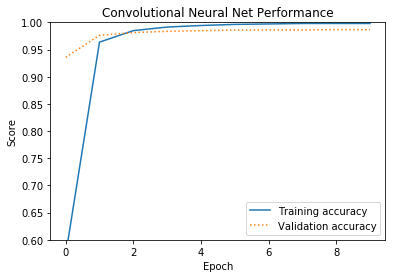

In [107]:
history = train_cnn.history
def historical_plotting():
    plt.plot(history['acc'], label='Training accuracy', linestyle='solid')
    plt.plot(history['val_acc'], label='Validation accuracy', linestyle='dotted')
    plt.legend()
    plt.ylim(0.6,1)
    plt.title("Convolutional Neural Net Performance")
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.show()
    
historical_plotting()

### Condense and run ###

Now that we've done everything procedurally, we can write up a tiny little function that takes in our input, preprocesses the image, runs the output selections through the neural net we trained, and outputs the best guesses for digits contained in the input.

In [183]:
 def do_all(image):
        im = readGray(image)
        squares = np.array(find_squares_anywhere(im, 10, 50, 2))
        digits = network.predict_classes(squares.reshape(squares.shape[0],28,28,1))
        return digits

In [187]:
network.predict_classes(np.array(test).reshape(np.array(test).shape[0],28,28,1))

array([2, 5, 1, 1, 6, 7, 8, 2, 2, 1, 1, 5, 7, 1, 2, 7], dtype=int64)